In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# for evaluation metrics
from sklearn.metrics import accuracy_score, f1_score


# set random seed
np.random.seed(0)
random.seed(0)

The MNIST database contains the dataset for this problem. Develop an image recognition algorithm using logistic regression based on gradient descent that can correctly classify handwritten images as 4 or not 4

## Load dataset
MNIST data can be downloaded from  http://yann.lecun.com/exdb/mnist/.

The training set contains 60000 images
The shape of the image is (28, 28)
The label of the image is 3


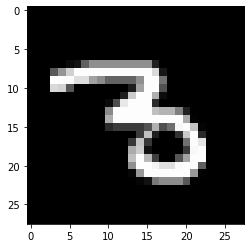

In [2]:
# load MNIST
path = '../MNIST/'   # the training set is stored in this directory

# Train data
fname_train_images = os.path.join(path, 'train-images-idx3-ubyte')  # the training set image file path
fname_train_labels = os.path.join(path, 'train-labels-idx1-ubyte')  # the training set label file path
    
# open the label file and load it to the "train_labels"
with open(fname_train_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    train_labels = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_train_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    train_images = np.fromfile(fimg, dtype=np.uint8).reshape(len(train_labels), rows, cols)
    
print('The training set contains', len(train_images), 'images')  # print the how many images contained in the training set
print('The shape of the image is', train_images[0].shape)  # print the shape of the image


imgNumber = 30  # choose which image you want to display
print('The label of the image is', train_labels[imgNumber])  # print the label of the image displayed

pyplot.imshow(train_images[imgNumber], cmap='gray')  # plot the image in "gray" colormap
pyplot.show()

In [3]:
# load test set

fname_test_images = os.path.join(path, 't10k-images-idx3-ubyte')  # the training set image file path
fname_test_labels = os.path.join(path, 't10k-labels-idx1-ubyte 2')  # the training set label file path
    
# open the label file and load it to the "train_labels"
with open(fname_test_labels, 'rb') as flbl:
    magic, num = struct.unpack(">II", flbl.read(8))
    test_y = np.fromfile(flbl, dtype=np.uint8)

# open the image file and load it to the "train_images"
with open(fname_test_images, 'rb') as fimg:
    magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
    test_X = np.fromfile(fimg, dtype=np.uint8).reshape(len(test_y), rows, cols)
    
print('The training set contains', len(test_X), 'images')  # print the how many images contained in the training set
print('The shape of the image is', test_X[0].shape)  # print the shape of the image

The training set contains 10000 images
The shape of the image is (28, 28)


## Preprocessing

Flatten. Typically, pictures are reshaped to column vectors. The images in the dataset are of size (28,28)
 and should be reshaped to column vectors of size (28x28,1).

In [4]:
train_X = np.reshape(train_images, (train_images.shape[0], -1))
train_X = train_X.T
train_X.shape

(784, 60000)

In [17]:
# set y as boolean: 4 or not 4
train_y = train_labels == 4
train_y.shape

(60000,)

In [6]:
# preprocess test set
test_X = np.reshape(test_X, (test_X.shape[0], -1))
test_X = test_X.T
test_X.shape

(784, 10000)

In [18]:
test_y = test_y == 4

For scaling of picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [7]:
train_X = train_X / 255
test_X = test_X / 255

The training data set contains 60,000 examples. Create smaller training datasets for development and validation. Investigate the impact of the training data size.

In [53]:
# # shuffle the samples to select randomly

# c = list(zip(train_X, train_labels))
# random.shuffle(c)
# train_X, train_y = zip(*c)

num_s = int(train_X.shape[1] * 0.8)
train_Xs = train_X[:,:num_s]
train_ys = train_y[:num_s]
val_Xs = train_X[:,num_s:] 

train_Xs.shape

(784, 48000)

## Learning

    • Use vectorized implementation.
    • Plot the learning curve (cost function vs. number of iterations).
    • Investigate the impact of the learning rate.

forward prop: 
$$ z = w^T X + b \\ 
A = sigma(z) = \frac{1}{1 + e^{-(w^T x + b)}} $$

Loss function:
$$J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$$

Back Prop:
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$



In [133]:
class LogisticRegression(object):
    '''
    Logistic regression build from scratch using numpy.
    Use gradient descent for training
    Vectorized for better performance
    Paramete

    Examples
    ---
    >>> LR = LogisticRegression(**arg)
    >>> LR.fit(X_trian, y_trian)
    '''

    def __init__(self, X_train, y_train, step_size = 0.1, tol = 1e-4, max_iter = 1000, random_seed = 0, verbal = True):
        self.verbal = verbal
        self.seed = random_seed
        np.random.seed(self.seed)
        self.step = step_size
        self.max_iter = max_iter
        self.X = X_train
        self.y = y_train
        self.p = X_train.shape[0] # parameter size
        self.m = X_train.shape[1] # number of samples
        ## random initiate parameters, sample from normal disrtibution
        self.w = np.random.randn(self.p)
        self.b = np.random.randn()
     
    ### training functions #####
    def forward_prop(self):
        self.z = np.dot(self.w.T, self.X) + self.b
        self.A = self.sigmoid(self.z)  # shape(1, m)
        
    def backward_prop(self):
        self.dz = self.A - self.y
        self.dw = np.dot(self.X, self.dz.T) / self.m
        self.db = np.sum(self.dz) / self.m
        
    def update(self):
        self.w -= self.step * self.dw
        self.b -= self.step * self.db

    def fit(self):
        self.costs = np.zeros(self.max_iter) # record costs
        
        for i in range(self.max_iter):
            self.forward_prop()
            self.costs[i] = self.cross_entropy_cost(self.A, self.y)
            self.backward_prop()
            self.update()
            
            if i % 100 == 0 and self.verbal:
                print("Cost after iteration %i : %f" %(i, self.costs[i]))
                
    def plot_curve(self):
        plt.plot(self.costs)
        plt.ylabel('Cost')
        plt.xlabel('Iterations')
        plt.title('learning rate: ' + str(self.step))
        plt.show()
    
    ### testing function ###
    def predict(self, X_test):
        # if sigmoid value >= 0.5, possitive
        A = self.sigmoid(np.dot(self.w.T, X_test) + self.b)
        return A >= 0.5
    
    def evaluate(self, test_X, test_y):
        # training score
        train_y_pred = self.predict(self.X)
        train_acc = accuracy_score(self.y, train_y_pred)
        train_f1 = f1_score(self.y, train_y_pred)
        print("Training accuracy: %.3f   F1 score: %.3f" %(train_acc, train_f1))
        # testing score
        test_y_pred = self.predict(test_X)
        test_acc = accuracy_score(test_y_pred, test_y)
        test_f1 = f1_score(test_y_pred, test_y)
        print("Testing accuracy: %.3f    F1 score: %.3f" %(test_acc, test_f1))

    #### helper functions ####
    def sigmoid(self, z):
        return 1/(1+ np.exp(-z))
    
    def cross_entropy_cost(self, A, y):
        '''
        A: prediction; 
        y: true value
        '''
        
        m = len(y) # number of samples
        return -(np.dot(np.log(A), y.T) + np.dot(np.log(1 - A), (1 - y.T)))/m


In [134]:
step = 1
RL = LogisticRegression(train_Xs, train_ys, step_size = step, max_iter = 500, verbal = True)
RL.fit()

Cost after iteration 0 : 1.385818
Cost after iteration 100 : 0.149249
Cost after iteration 200 : 0.117219
Cost after iteration 300 : 0.102860
Cost after iteration 400 : 0.094140


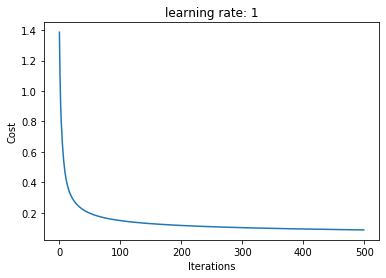

In [135]:
RL.plot_curve()

## Evaluation

    • Compute the training and the test error.
    • Try test examples.

In [136]:
RL.evaluate(test_X, test_y)

Training accuracy: 0.973   F1 score: 0.858
Testing accuracy: 0.974    F1 score: 0.868


The result shows that using 80% training sample, logistic regerssion without regularization can already achieve high accuracy and F1 score.

## Infulence of size of traing data

In [138]:
import time
for portion in [0.3, 0.6, 1]:
    # use just portion of data
    num_s = int(train_X.shape[1] * portion)
    train_Xs = train_X[:,:num_s]
    train_ys = train_y[:num_s]
    LR = LogisticRegression(train_Xs, train_ys, step_size = 0.1,  max_iter = 1000, verbal = False)
    # time the training process
    tic = time.clock()
    LR.fit()
    fitT = time.clock() - tic
    print("Using %.2f of training data, %d samples in toal, training took %.2f seconds" %(portion, num_s, fitT))
    # evaluate
    LR.evaluate(test_X, test_y)
    print('---------------')

Using 0.30 of training data, 18000 samples in toal, training took 18.83 seconds
Training accuracy: 0.957   F1 score: 0.780
Testing accuracy: 0.956    F1 score: 0.773
---------------
Using 0.60 of training data, 36000 samples in toal, training took 80.40 seconds
Training accuracy: 0.956   F1 score: 0.774
Testing accuracy: 0.958    F1 score: 0.782
---------------
Using 1.00 of training data, 60000 samples in toal, training took 138.13 seconds
Training accuracy: 0.956   F1 score: 0.776
Testing accuracy: 0.956    F1 score: 0.775
---------------


We can see that a small portion of the total training data (30%) can already achieve good results with significantly less time. Meanwhile, using less data samples, the training F1 score is higher, but the testing F1 score is lower. This shows that overfitting might be happening with less data samples, leading to less generalization abilities.

## Influence of learning rate

In [159]:
# use 50% of training data
num_s = int(train_X.shape[1] * 0.5)
train_Xs = train_X[:,:num_s]
train_ys = train_y[:num_s]
Tcosts = []
for step in [1, 0.1, 0.01]:
    LR = LogisticRegression(train_Xs, train_ys, step_size = step, max_iter = 5000, verbal = False)
    print("step size: %.2f" %(step))
    LR.fit()
    LR.evaluate(test_X, test_y)
    # record the cost curve
    Tcosts.append(LR.costs)
    print('---------------')

step size: 1.00
Training accuracy: 0.985   F1 score: 0.921
Testing accuracy: 0.981    F1 score: 0.903
---------------
step size: 0.10
Training accuracy: 0.974   F1 score: 0.867
Testing accuracy: 0.974    F1 score: 0.868
---------------
step size: 0.01
Training accuracy: 0.942   F1 score: 0.702
Testing accuracy: 0.943    F1 score: 0.706
---------------


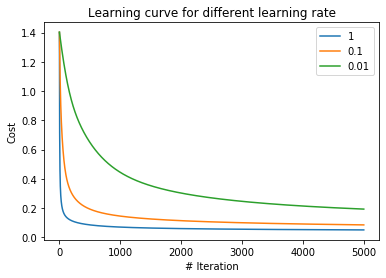

In [176]:
for cost in Tcosts:
    plt.plot(cost)
plt.xlabel('# Iteration')
plt.ylabel('Cost')
plt.legend(("1", "0.1", "0.01"))
plt.title("Learning curve for different learning rate" )
plt.show()

We can see from the learning curve that a higher learning rate can converge to optimal solution faster, but the gap between the costs for different learning rate is geting smaller as the numner fo iteration grows. In general, if learning rate is too small, it may take too long to coverge, whereas if learning rate is too large, it might not be able to converge at last.

## Example of miss-classified image

In [165]:
miss_classified = test_X[:, LR.predict(test_X) != test_y]

In [167]:
miss_classified.shape

(784, 575)

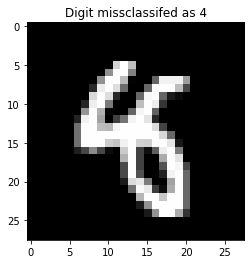

In [177]:
sample = miss_classified[:, 20] * 255
sample = np.reshape(sample, [28,28])
pyplot.imshow(sample, cmap='gray')  # plot the image in "gray" colormap
pyplot.title("Digit missclassifed as 4")
pyplot.show()